### Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense,LSTM,Dropout
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score,mean_squared_error
import matplotlib.dates as madates
from sklearn import linear_model
from tensorflow.keras import Sequential
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model




%matplotlib inline        


In [2]:


stock_df = pd.read_csv(r"C:\Users\sanat\Downloads\MSFT.csv",na_values=['null'],index_col='Date',parse_dates=True,infer_datetime_format=True)
stock_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-06-09,267.779999,272.709991,264.630005,264.790009,262.255035,26439700
2022-06-10,260.579987,260.579987,252.529999,252.990005,250.567963,31422800
2022-06-13,245.110001,249.020004,241.529999,242.259995,239.940674,46135800
2022-06-14,243.860001,245.740005,241.509995,244.490005,242.149353,28651500
2022-06-15,248.309998,255.300003,246.419998,251.759995,249.349731,33111700


In [3]:
print(f"Shape of dataframe: {stock_df.shape}")
print(f"Null values: {stock_df.isnull().values.any()}")

Shape of dataframe: (251, 6)
Null values: False


## Plotting the adjusted close values

Adjusted close value is the value of the stock at the end of the day's trading activities

<Axes: xlabel='Date', ylabel='Adjusted Close'>

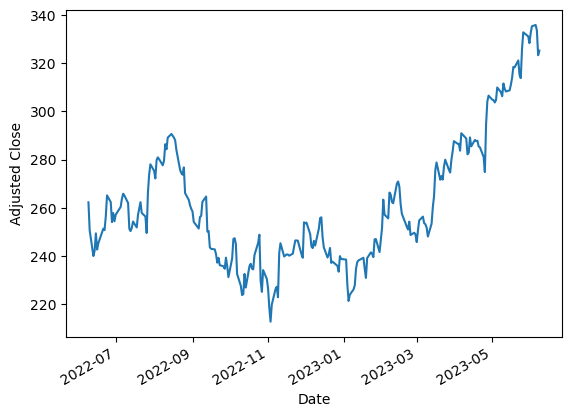

In [4]:
stock_df['Adj Close'].plot(kind='line',ylabel="Adjusted Close")

## Defining target variable and feature space

In [5]:
feats = stock_df.drop('Adj Close',axis=1)
target = stock_df['Adj Close']

## Scaling

Scale the feature space to values in the range [0,1] using MinMax Scaler. Helps for stability of gradient descent by ensuring values of the partial derivatives are neither too small nor too large. No need to scale the response since we want the response variable to be the actual close values and not a scaled version.

We do not scale the response because scaling biases evaluation metrics, leading us to believe that the model is a lot better than it actually is.

In [6]:
scaler = MinMaxScaler()
scaled_feats = scaler.fit_transform(feats)
scaled_feats[:5,:]

array([[0.42647311, 0.44265755, 0.42233777, 0.41531768, 0.22416945],
       [0.36534208, 0.33999141, 0.32252745, 0.31834994, 0.28896818],
       [0.2339956 , 0.24214982, 0.23179084, 0.23017499, 0.48029159],
       [0.22338259, 0.21438851, 0.23162583, 0.24850032, 0.25293103],
       [0.26116488, 0.29530259, 0.27212738, 0.30824221, 0.31093013]])

MinMaxScaler returns a NumPy array, so we convert it back to a DataFrame so that we can split the data on dates

In [7]:
scaled_df = pd.DataFrame(data=scaled_feats,columns=feats.columns,index=stock_df.index)

In [8]:
scaled_df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2022-06-09,0.426473,0.442658,0.422338,0.415318,0.224169
2022-06-10,0.365342,0.339991,0.322527,0.318350,0.288968
2022-06-13,0.233996,0.242150,0.231791,0.230175,0.480292
2022-06-14,0.223383,0.214389,0.231626,0.248500,0.252931
2022-06-15,0.261165,0.295303,0.272127,0.308242,0.310930


In [9]:
ts_split = TimeSeriesSplit(n_splits=10)
for train_split, test_split in ts_split.split(scaled_df):
    x_train,x_test = scaled_df[:len(train_split)], scaled_df[len(train_split):len(train_split)+len(test_split)]
    y_train,y_test = target[:len(train_split)], target[len(train_split):len(train_split)+len(test_split)]
    
print(f"Shape of X_train: {x_train.shape}")
print(f"Shape of X_test: {x_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_train: {y_test.shape}")

Shape of X_train: (229, 5)
Shape of X_test: (22, 5)
Shape of y_train: (229,)
Shape of y_train: (22,)


To pass our feature set as input to the LSTM layer, we need to reshape the input to: (batch_size,num_timesteps,num_features). We have 5 features and we want to predict for only one instance of time, therefore num_timesteps=1

In [10]:
x_train = np.array(x_train)
x_train = x_train.reshape(x_train.shape[0],1,x_train.shape[1])

x_test = np.array(x_test)
x_test = x_test.reshape(x_test.shape[0],1,x_test.shape[1])


## Defining Model Architecture

In [11]:
import tensorflow as tf
inputs = tf.random.normal(x_train.shape)
out = LSTM(32,input_shape=(1,x_train.shape[2]),activation="relu",return_sequences=True)(inputs)
out2 = LSTM(64,input_shape=(None,None,32),activation="relu",return_sequences=False)(out)
out2.shape

TensorShape([229, 64])

In [16]:
model = Sequential()
model.add(LSTM(32,input_shape=(1,x_train.shape[2]),activation="relu",return_sequences=True))   # Set return_sequences=False since we need point predictions
model.add(LSTM(64,input_shape=(None,None,32),activation="relu",return_sequences=True))   # Set return_sequences=False since we need point predictions
model.add(LSTM(32,input_shape=(None,None,64),activation="relu",return_sequences=False))   # Set return_sequences=False since we need point predictions
model.add(Dense(1))

# Compile the model
model.compile(loss="mean_squared_error",optimizer="adam")

    

In [17]:
hist = model.fit(x_train,y_train,epochs=150,batch_size=8,verbose=1,shuffle=False)

Epoch 1/150
29/29 [==============================] - 5s 4ms/step - loss: 65968.5078
Epoch 2/150
29/29 [==============================] - 0s 4ms/step - loss: 65905.2969
Epoch 3/150
29/29 [==============================] - 0s 5ms/step - loss: 65612.8984
Epoch 4/150
29/29 [==============================] - 0s 4ms/step - loss: 63350.0391
Epoch 5/150
29/29 [==============================] - 0s 4ms/step - loss: 52526.9648
Epoch 6/150
29/29 [==============================] - 0s 5ms/step - loss: 28168.4941
Epoch 7/150
29/29 [==============================] - 0s 5ms/step - loss: 10319.8887
Epoch 8/150
29/29 [==============================] - 0s 4ms/step - loss: 5981.1250
Epoch 9/150
29/29 [==============================] - 0s 4ms/step - loss: 5689.9199
Epoch 10/150
29/29 [==============================] - 0s 4ms/step - loss: 5131.9951
Epoch 11/150
29/29 [==============================] - 0s 5ms/step - loss: 4675.5835
Epoch 12/150
29/29 [==============================] - 0s 4ms/step - loss: 4292

29/29 [==============================] - 0s 5ms/step - loss: 29.6351
Epoch 100/150
29/29 [==============================] - 0s 4ms/step - loss: 27.6519
Epoch 101/150
29/29 [==============================] - 0s 4ms/step - loss: 25.7885
Epoch 102/150
29/29 [==============================] - 0s 4ms/step - loss: 24.0398
Epoch 103/150
29/29 [==============================] - 0s 5ms/step - loss: 22.4010
Epoch 104/150
29/29 [==============================] - 0s 4ms/step - loss: 20.8672
Epoch 105/150
29/29 [==============================] - 0s 4ms/step - loss: 19.4338
Epoch 106/150
29/29 [==============================] - 0s 5ms/step - loss: 18.0962
Epoch 107/150
29/29 [==============================] - 0s 4ms/step - loss: 16.8498
Epoch 108/150
29/29 [==============================] - 0s 4ms/step - loss: 15.6902
Epoch 109/150
29/29 [==============================] - 0s 4ms/step - loss: 14.6132
Epoch 110/150
29/29 [==============================] - 0s 5ms/step - loss: 13.6146
Epoch 111/150
29/2

Text(0.5, 1.0, 'Training Loss vs Epochs')

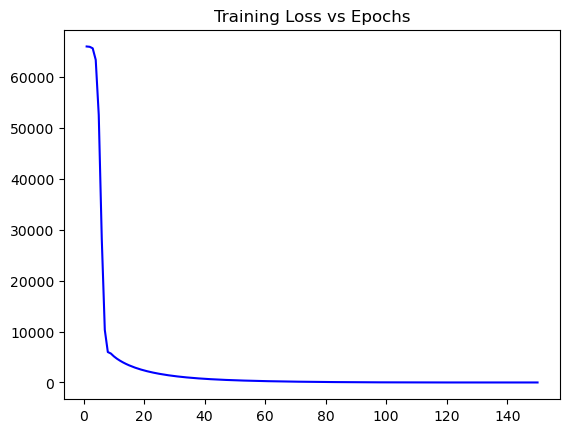

In [20]:
# Plotting the loss curve to validate training process

history_dict = hist.history

plt.plot(range(1,151),history_dict['loss'],'b-')
plt.title("Training Loss vs Epochs")

The training loss decreases exponentially as training progresses, indicating that the model has trained correctly.

## Predictions


In [21]:
preds = model.predict(x_test)

1/1 [==============================] - 0s 490ms/step


## Plotting true and predicted Adjusted Close Values

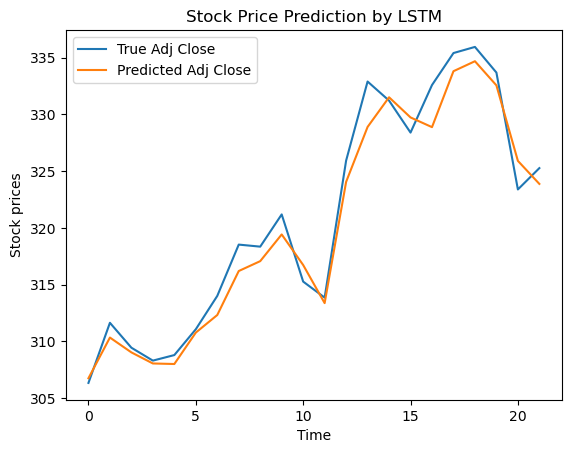

In [22]:
plt.plot(range(y_test.shape[0]),y_test.values,label="True Adj Close")
plt.plot(range(y_test.shape[0]),preds,label="Predicted Adj Close")
plt.xlabel("Time")
plt.ylabel("Stock prices")
plt.title("Stock Price Prediction by LSTM")
plt.legend()
plt.show()

This comparison graph reinforces our beliefs about the pros and cons about using Vanilla LSTMs. For one, our model is able to capture the general daily trend in Microsoft Stock Prices. While the model works well when it comes to predicting ~12 days into the future, the predictions get significantly worse beyond that. This is because a vanilla LSTM struggles to handle longer sequences and predictions get worse because of the problem of exploding and vanishing gradients. 